# Clustering in Real World
> A Summary of lecture "Cluster Analysis in Python", via datacamp

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Machine Learning]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dominant colors in images
- Dominant colors in images
    - All images consist of pixels
    - Each pixel has three values: R, G, B
    - Pixel Color: combination of these RGB values
    - Perform k-means on standardized RGB values to find cluster centers
    - Uses: Identifying features in statelite images

### Extract RGB values from image
There are broadly three steps to find the dominant colors in an image:

- Extract RGB values into three lists.
- Perform k-means clustering on scaled RGB values.
- Display the colors of cluster centers.
![batman](dataset/batman.jpg)

In [2]:
import matplotlib.image as img

r = []
g = []
b = []

# Read batman image and print dimensions
batman_image = img.imread('./dataset/batman.jpg')
print(batman_image.shape)

# Store RGB values of all pixels in lists r, g, and b
for row in batman_image:
    for temp_r, temp_g, temp_b in row: 
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

(169, 269, 3)


### How many dominant colors?
Construct an elbow plot with the data frame. How many dominant colors are present?

- Preprocess

In [3]:
from scipy.cluster.vq import whiten

batman_df = pd.DataFrame({'red':r, 'blue':b, 'green':g})
batman_df['scaled_red'] = whiten(batman_df['red'])
batman_df['scaled_blue'] = whiten(batman_df['blue'])
batman_df['scaled_green'] = whiten(batman_df['green'])

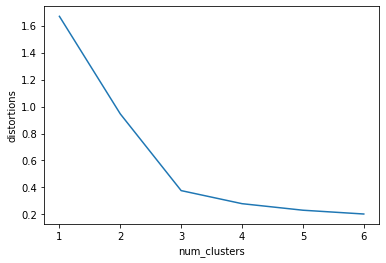

In [5]:
from scipy.cluster.vq import kmeans

distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(batman_df[['scaled_red', 'scaled_blue', 'scaled_green']], i)
    distortions.append(distortion)
    
# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data=elbow_plot);
plt.xticks(num_clusters);

### Display dominant colors
To display the dominant colors, convert the colors of the cluster centers to their raw values and then converted them to the range of 0-1, using the following formula: 
```python
converted_pixel = standardized_pixel * pixel_std / 255
```

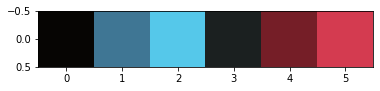

In [7]:
colors = []

# Get standard deviations of each color
r_std, g_std, b_std = batman_df[['red', 'green', 'blue']].std()

for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    # Convert each standardized value to scaled value
    colors.append((
        scaled_r * r_std / 255.0,
        scaled_g * g_std / 255.0,
        scaled_b * b_std / 255.0
        )
    )
    
# Display colors of cluster centers
plt.imshow([colors])

## Document clustering
- Document clustering: concepts
    - 1. Clean data before processing
    - 2. Determine the importance of the terms in a document (in tf-idf matrix)
    - 3. Cluster the tf-idf matrix
    - 4. Find top terms, documents in each cluster
- TF-IDF (Term Frequency - Inverse Document Frequency)
    - A weighted measure: evaluate how important a word is to a document in a collection
- Top terms per cluster
    - Cluster centers: lists with a size equal to the number of terms
    - Each value in the cluster center is its importance
- More considerations
    - Work with hyperlinks, emoticons etc.
    - Normalize words (e.g. run, ran, running -> run)
    - ```.todense()``` may not work with large datasets

### TF-IDF of movie plots
Let us use the plots of randomly selected movies to perform document clustering on. Before performing clustering on documents, they need to be cleaned of any unwanted noise (such as special characters and stop words) and converted into a sparse matrix through TF-IDF of the documents.

Use the ```TfidfVectorizer``` class to perform the TF-IDF of movie plots stored in the list ```plots```. The ```remove_noise()``` function is available to use as a ```tokenizer``` in the ```TfidfVectorizer``` class. The ```.fit_transform()``` method fits the data into the ```TfidfVectorizer``` objects and then generates the TF-IDF sparse matrix.

**Note: It takes a few seconds to run the ```.fit_transform()``` method.**

- Preprocess

In [22]:
movie = pd.read_csv('./dataset/movies_plot.csv')
movie.head()

,Title,Plot
0,The Ballad of Cable Hogue,"Cable Hogue is isolated in the desert, awaitin..."
1,Monsters vs. Aliens,"In the far reaches of space, a planet explodes..."
2,The Bandit Queen,Zarra Montalvo is the daughter of an American ...
3,Broken Arrow,Major Vic Deakins (John Travolta) and Captain ...
4,Dolemite,Dolemite is a pimp and nightclub owner who is ...


In [23]:
plots = movie['Plot'].values

In [24]:
from nltk.tokenize import word_tokenize
import re

import nltk
nltk.download('punkt')

def remove_noise(text, stop_words = []):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kcsgo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.75, max_features=50, tokenizer=remove_noise)

# Use the .fit_transform() on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(plots)

### Top terms in movie clusters
Now that you have created a sparse matrix, generate cluster centers and print the top three terms in each cluster. Use the ```.todense()``` method to convert the sparse matrix, ```tfidf_matrix``` to a normal matrix for the ```kmeans()``` function to process. Then, use the ```.get_feature_names()``` method to get a list of terms in the ```tfidf_vectorizer``` object. The zip() function in Python joins two lists.

With a higher number of data points, the clusters formed would be defined more clearly. However, this requires some computational power, making it difficult to accomplish in an exercise here.



In [26]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:3])

['him', 'they', 'who']
['her', 'she', 'him']


## Clustering with multiple features


### Basic checks on clusters
In the FIFA 18 dataset, we have concentrated on defenders in previous exercises. Let us try to focus on attacking attributes of a player. Pace (```pac```), Dribbling (```dri```) and Shooting (```sho```) are features that are present in attack minded players. In this exercise, k-means clustering has already been applied on the data using the scaled values of these three attributes. Try some basic checks on the clusters so formed.



- Preprocess

In [27]:
fifa = pd.read_csv('./dataset/fifa_18_sample_data.csv')
fifa.head()

,ID,name,full_name,club,club_logo,special,age,league,birth_date,height_cm,...,prefers_cb,prefers_lb,prefers_lwb,prefers_ls,prefers_lf,prefers_lam,prefers_lcm,prefers_ldm,prefers_lcb,prefers_gk
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,https://cdn.sofifa.org/18/teams/243.png,2228,32,Spanish Primera División,1985-02-05,185.0,...,False,False,False,False,False,False,False,False,False,False
1,158023,L. Messi,Lionel Messi,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2158,30,Spanish Primera División,1987-06-24,170.0,...,False,False,False,False,False,False,False,False,False,False
2,190871,Neymar,Neymar da Silva Santos Jr.,Paris Saint-Germain,https://cdn.sofifa.org/18/teams/73.png,2100,25,French Ligue 1,1992-02-05,175.0,...,False,False,False,False,False,False,False,False,False,False
3,176580,L. Suárez,Luis Suárez,FC Barcelona,https://cdn.sofifa.org/18/teams/241.png,2291,30,Spanish Primera División,1987-01-24,182.0,...,False,False,False,False,False,False,False,False,False,False
4,167495,M. Neuer,Manuel Neuer,FC Bayern Munich,https://cdn.sofifa.org/18/teams/21.png,1493,31,German Bundesliga,1986-03-27,193.0,...,False,False,False,False,False,False,False,False,False,True


In [29]:
fifa['scaled_pac'] = whiten(fifa['pac'])
fifa['scaled_dri'] = whiten(fifa['dri'])
fifa['scaled_sho'] = whiten(fifa['sho'])

In [31]:
from scipy.cluster.vq import vq

cluster_centers, _ = kmeans(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], 3)

fifa['cluster_labels'], _ = vq(fifa[['scaled_pac', 'scaled_dri', 'scaled_sho']], cluster_centers)

In [33]:
# Print the size of the clusters
print(fifa.groupby('cluster_labels')['ID'].count())

# Print the mean value of wages in each cluster
print(fifa.groupby('cluster_labels')['eur_wage'].mean())

cluster_labels
0    182
1    361
2    457
Name: ID, dtype: int64
cluster_labels
0    63225.274725
1    62603.878116
2    77297.592998
Name: eur_wage, dtype: float64


### FIFA 18: what makes a complete player?
The overall level of a player in FIFA 18 is defined by six characteristics: pace (```pac```), shooting (```sho```), passing (```pas```), dribbling (```dri```), defending (```def```), physical (```phy```).

In [36]:
fifa['scaled_def'] = whiten(fifa['def'])
fifa['scaled_phy'] = whiten(fifa['phy'])

In [39]:
scaled_features = ['scaled_pac', 'scaled_sho', 'scaled_pac', 'scaled_dri', 'scaled_def', 'scaled_phy']

                scaled_pac  scaled_sho  scaled_pac  scaled_dri  scaled_def  \
cluster_labels                                                               
0                 5.491062    3.998012    5.491062    7.059324    3.858428   
1                 6.828114    5.475576    6.828114    8.579753    2.366369   

                scaled_phy  
cluster_labels              
0                 9.109248  
1                 8.274933  
1 ['Cristiano Ronaldo' 'L. Messi' 'Neymar' 'L. Suárez' 'M. Neuer']
0 ['T. Kroos' 'Sergio Ramos' 'G. Chiellini' 'L. Bonucci' 'J. Boateng']


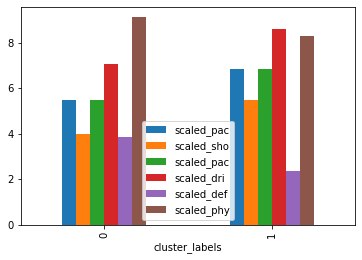

In [40]:
# Create centroids with kmeans for 2 clusters
cluster_centers, _ = kmeans(fifa[scaled_features], 2)

# Assign cluster labels and print cluster centers
fifa['cluster_labels'], _ = vq(fifa[scaled_features], cluster_centers)
print(fifa.groupby('cluster_labels')[scaled_features].mean())

# Plot cluster centers to visualize clusters
fifa.groupby('cluster_labels')[scaled_features].mean().plot(legend=True, kind='bar')

# Get the name column of first 5 players in each cluster
for cluster in fifa['cluster_labels'].unique():
    print(cluster, fifa[fifa['cluster_labels'] == cluster]['name'].values[:5])